## Exercise 4- Neural Networks Learning

In [1]:
# import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io 
import matplotlib.cm as cm 
import random 
import scipy.optimize
import itertools
from scipy.special import expit

In [2]:
input_file = 'database/ex4data1.mat'

# scipy.io for loading .mat files
mat_data = scipy.io.loadmat(input_file)
X, y = mat_data['X'], mat_data['y']

# insert ones to X (x0)
X = np.insert(X,0,1,axis=1)

# displaying shapes of X & y
print(X.shape ,mat_data['y'].shape)

# X contains 5000 images, therefore 5000 rows. Each image has 400 pixels unrolled (20x20).
# y is a classification for each image. 1-10, where "10" is the handwritten "0"

(5000, 401) (5000, 1)


In [3]:
# creating a function to display matrix as an image
# reference- https://github.com/scipy/scipy/blob/368dbad596a0bd0d5a88a7aec381fdc912440ee1/scipy/misc/pilutil.py#L286-L409
import numpy as np
from PIL import Image


_errstr = "Mode is unknown or incompatible with input array shape."


def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).
    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.
    This function is only available if Python Imaging Library (PIL) is installed.
    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.
    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.
    Examples
    --------
    >>> from scipy.misc import bytescale
    >>> img = np.array([[ 91.06794177,   3.39058326,  84.4221549 ],
    ...                 [ 73.88003259,  80.91433048,   4.88878881],
    ...                 [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)
    """
    if data.dtype == np.uint8:
        return data

    if high > 255:
        raise ValueError("`high` should be less than or equal to 255.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint8)


def toimage(arr, high=255, low=0, cmin=None, cmax=None, pal=None,
            mode=None, channel_axis=None):
    """Takes a numpy array and returns a PIL image.
    This function is only available if Python Imaging Library (PIL) is installed.
    The mode of the PIL image depends on the array shape and the `pal` and
    `mode` keywords.
    For 2-D arrays, if `pal` is a valid (N,3) byte-array giving the RGB values
    (from 0 to 255) then ``mode='P'``, otherwise ``mode='L'``, unless mode
    is given as 'F' or 'I' in which case a float and/or integer array is made.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Notes
    -----
    For 3-D arrays, the `channel_axis` argument tells which dimension of the
    array holds the channel data.
    For 3-D arrays if one of the dimensions is 3, the mode is 'RGB'
    by default or 'YCbCr' if selected.
    The numpy array must be either 2 dimensional or 3 dimensional.
    """
    data = np.asarray(arr)
    if np.iscomplexobj(data):
        raise ValueError("Cannot convert a complex-valued array.")
    shape = list(data.shape)
    valid = len(shape) == 2 or ((len(shape) == 3) and
                                ((3 in shape) or (4 in shape)))
    if not valid:
        raise ValueError("'arr' does not have a suitable array shape for "
                         "any mode.")
    if len(shape) == 2:
        shape = (shape[1], shape[0])  # columns show up first
        if mode == 'F':
            data32 = data.astype(np.float32)
            image = Image.frombytes(mode, shape, data32.tostring())
            return image
        if mode in [None, 'L', 'P']:
            bytedata = bytescale(data, high=high, low=low,
                                 cmin=cmin, cmax=cmax)
            image = Image.frombytes('L', shape, bytedata.tostring())
            if pal is not None:
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
                # Becomes a mode='P' automagically.
            elif mode == 'P':  # default gray-scale
                pal = (np.arange(0, 256, 1, dtype=np.uint8)[:, np.newaxis] *
                       np.ones((3,), dtype=np.uint8)[np.newaxis, :])
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
            return image
        if mode == '1':  # high input gives threshold for 1
            bytedata = (data > high)
            image = Image.frombytes('1', shape, bytedata.tostring())
            return image
        if cmin is None:
            cmin = np.amin(np.ravel(data))
        if cmax is None:
            cmax = np.amax(np.ravel(data))
        data = (data*1.0 - cmin)*(high - low)/(cmax - cmin) + low
        if mode == 'I':
            data32 = data.astype(np.uint32)
            image = Image.frombytes(mode, shape, data32.tostring())
        else:
            raise ValueError(_errstr)
        return image

    # if here then 3-d array with a 3 or a 4 in the shape length.
    # Check for 3 in datacube shape --- 'RGB' or 'YCbCr'
    if channel_axis is None:
        if (3 in shape):
            ca = np.flatnonzero(np.asarray(shape) == 3)[0]
        else:
            ca = np.flatnonzero(np.asarray(shape) == 4)
            if len(ca):
                ca = ca[0]
            else:
                raise ValueError("Could not find channel dimension.")
    else:
        ca = channel_axis

    numch = shape[ca]
    if numch not in [3, 4]:
        raise ValueError("Channel axis dimension is not valid.")

    bytedata = bytescale(data, high=high, low=low, cmin=cmin, cmax=cmax)
    if ca == 2:
        strdata = bytedata.tostring()
        shape = (shape[1], shape[0])
    elif ca == 1:
        strdata = np.transpose(bytedata, (0, 2, 1)).tostring()
        shape = (shape[2], shape[0])
    elif ca == 0:
        strdata = np.transpose(bytedata, (1, 2, 0)).tostring()
        shape = (shape[2], shape[1])
    if mode is None:
        if numch == 3:
            mode = 'RGB'
        else:
            mode = 'RGBA'

    if mode not in ['RGB', 'RGBA', 'YCbCr', 'CMYK']:
        raise ValueError(_errstr)

    if mode in ['RGB', 'YCbCr']:
        if numch != 3:
            raise ValueError("Invalid array shape for mode.")
    if mode in ['RGBA', 'CMYK']:
        if numch != 4:
            raise ValueError("Invalid array shape for mode.")

    # Here we know data and mode is correct
    image = Image.frombytes(mode, shape, strdata)
    return image

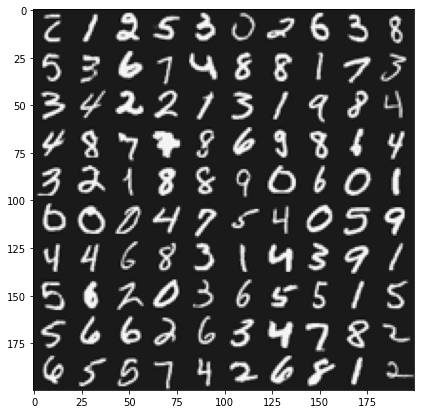

In [4]:
def getImage(x):
    """
    Input: np array with shape 1*400
    Output: image object 
    """
    w, h = 20, 20
    sq = x[1:].reshape(w,h)
    return sq.T
    
def displayData(display_indices = None):
    """
    Picks 100 random rows from X, creates a grid of images, and displays the same.
    """
    w, h = 20, 20
    num_rows, num_columns = 10, 10
    if not display_indices:
        display_indices = random.sample(range(X.shape[0]), num_rows*num_columns)
        
    grid_images = np.zeros((h*num_rows,w*num_columns))
    
    row_i, col_i = 0, 0
    for i in display_indices:
        if col_i == num_columns:
            row_i += 1
            col_i  = 0
        img_i = getImage(X[i])
        grid_images[row_i*h:row_i*h+img_i.shape[0],col_i*w:col_i*w+img_i.shape[1]] = img_i
        col_i += 1
    fig = plt.figure(figsize=(7,7))
    image = toimage(grid_images) # displays matrix as an image
    plt.imshow(image,cmap = cm.Greys_r)
    
displayData()

In [5]:
# we have been provided with a set of network parameters (Θ(1),Θ(2)) already trained by us. These are stored in ex3weights.mat
input_file = 'database/ex4weights.mat'

mat_data = scipy.io.loadmat(input_file)
Theta1, Theta2 = mat_data['Theta1'], mat_data['Theta2']

print ("Theta1 shape: ",Theta1.shape)
print ("Theta2 shape: ",Theta2.shape)

Theta1 shape:  (25, 401)
Theta2 shape:  (10, 26)


In [6]:
# global variables as per matrix sizes, excluding bias terms
input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10 
num_training_samples = X.shape[0]

In [7]:
# functions for data preparation

# matrices to vector
def flattenParams(theta_list):
    flattened_list = [theta.flatten() for theta in theta_list]
    combined = list(itertools.chain.from_iterable(flattened_list))
    assert len(combined) == (input_layer_size+1)*hidden_layer_size + \
                            (hidden_layer_size+1)*output_layer_size
    return np.array(combined).reshape((len(combined),1))

# reshaping parameters
def reshapeParameters(flattened_array):
    theta1 = flattened_array[:(input_layer_size+1)*hidden_layer_size] \
            .reshape((hidden_layer_size,input_layer_size+1))
    theta2 = flattened_array[(input_layer_size+1)*hidden_layer_size:] \
            .reshape((output_layer_size,hidden_layer_size+1))
    
    return [theta1, theta2]

def flattenX(X):
    return np.array(X.flatten()).reshape((num_training_samples*(input_layer_size+1),1))

def reshapeX(flattenedX):
    return np.array(flattenedX).reshape((num_training_samples,input_layer_size+1))

### Feedforward function

In [8]:
def computeCost(thetas_flattened,X_flattened,y,_lambda=0.):
    """
    This function takes in:
        1) a flattened vector of theta parameters (each theta would go from one
           NN layer to the next), the thetas include the bias unit.
        2) the flattened training set matrix X, which contains the bias unit first column
        3) the label vector y, which has one column
        
    It loops over training points, and:
        1) constructs a new "y" vector, with 10 rows and 1 column, 
           with one non-zero entry corresponding to that iteration
        2) computes the cost given that y-vector and that training point
        3) aggregates all of the costs
        4) calculates a regularization term (after looping is done)
    """
    
    # unroll parameters & X
    thetas = reshapeParameters(thetas_flattened)
    X = reshapeX(X_flattened)
    
    total_cost = 0.
    
    m = num_training_samples

    # looping
    for row_i in range(m):
        row = X[row_i]

        hs = propagateForward(row,thetas)[-1][1]

        temp_y  = np.zeros((10,1))
        temp_y[y[row_i]-1] = 1
        
        # calculating the cost for this point and y-vector
        cost = -temp_y.T.dot(np.log(hs))-(1-temp_y.T).dot(np.log(1-hs))

        # aggregate the total cost
        total_cost += cost
        
    # normalizing the total_cost
    total_cost = float(total_cost) / m
    
    # calculating the regularization term
    total_reg = 0.
    for theta in thetas:
        total_reg += np.sum(theta*theta)
    total_reg *= float(_lambda)/(2*m)
        
    return total_cost + total_reg
       

def propagateForward(row,Thetas):
    """
    Function that given a list of Thetas (NOT flattened), propagates the
    row of features forwards, assuming the features ALREADY
    include the bias unit in the input layer, and the 
    Thetas also include the bias unit

    The output is a vector with element [0] for the hidden layer,
    and element [1] for the output layer
        -- Each element is a tuple of (zs, as)
        -- where "zs" and "as" have shape (# of units in that layer, 1)
    
    Note:
    The 'activations' are the same as "h", but this works for many layers (hence a vector of thetas, not just one theta)
    "h" is vectorized to do all rows at once, this function takes in one row at a time
    """
    
    features = row
    Zs_as_per_layer = []
    for i in range(len(Thetas)):  
        Theta = Thetas[i]

        z = Theta.dot(features).reshape((Theta.shape[0],1))
        a = expit(z)
        Zs_as_per_layer.append((z, a))
        if i == len(Thetas)-1:
            return np.array(Zs_as_per_layer)
        a = np.insert(a,0,1) # adding the bias unit
        features = a

In [9]:
Thetas = [Theta1, Theta2]

# unregularized cost
print ("Unregularized Cost (Lambda=0): ", computeCost(flattenParams(Thetas),flattenX(X),y))

# regularized cost
print ("Regularized Cost (Lambda=1): ", computeCost(flattenParams(Thetas),flattenX(X),y, _lambda=1))

Unregularized Cost (Lambda=0):  0.28762916516131887
Regularized Cost (Lambda=1):  0.3844877962428939


### Backpropagation

In [10]:
# sigmoid gradient
def sigmoidGradient(x):
    temp = expit(x)
    return temp*(1-temp)

# random initialization
def genRandomThetas():
    epsilon = 0.15
    shape_theta1 = (hidden_layer_size, input_layer_size+1)
    shape_theta2 = (output_layer_size, hidden_layer_size+1)
    random_thetas = [np.random.rand( *shape_theta1) * 2 * epsilon - epsilon, \
                    np.random.rand( *shape_theta2) * 2 * epsilon - epsilon]
    return random_thetas

In [11]:
def backPropagate(thetas_flattened,X_flattened,y,_lambda=0.):
    
    # unroll parameters & X
    thetas = reshapeParameters(thetas_flattened)
    X = reshapeX(X_flattened)

    # Note: the Delta matrices should include the bias unit
    Delta1 = np.zeros((hidden_layer_size,input_layer_size+1))
    Delta2 = np.zeros((output_layer_size,hidden_layer_size+1))

    # looping over the training points (rows in X, already contain the bias unit)
    m = num_training_samples
    for row_i in range(m):
        row = X[row_i]
        a1 = row.reshape((input_layer_size+1,1))
        # propagateForward returns (zs, activations) for each layer excluding the input layer
        temp = propagateForward(row,thetas)
        z2 = temp[0][0]
        a2 = temp[0][1]
        z3 = temp[1][0]
        a3 = temp[1][1]
        temp_y = np.zeros((10,1))
        temp_y[y[row_i]-1] = 1
        d3 = a3 - temp_y 
        d2 = thetas[1].T[1:,:].dot(d3)*sigmoidGradient(z2)
        a2 = np.insert(a2,0,1,axis=0)
        Delta1 += d2.dot(a1.T) 
        Delta2 += d3.dot(a2.T) 
        
    D1 = Delta1/float(m)
    D2 = Delta2/float(m)
    
    # regularizing
    D1[:,1:] = D1[:,1:] + (float(_lambda)/m)*thetas[0][:,1:]
    D2[:,1:] = D2[:,1:] + (float(_lambda)/m)*thetas[1][:,1:]
    
    return flattenParams([D1, D2]).flatten()

# computing D matrices for the Thetas provided
flattened_D1D2 = backPropagate(flattenParams(Thetas),flattenX(X),y,_lambda=0.)
D1, D2 = reshapeParameters(flattened_D1D2)
# display(D1,D2)

In [12]:
# gradient checking
def checkGradient(thetas,Ds,X,y,_lambda=0.):
    epsilon = 0.0001
    flattened = flattenParams(thetas)
    flattened_Ds = flattenParams(Ds)
    X_flattened = flattenX(X)
    num_elems = len(flattened) 
    # pick 5 random elements, compute numerical gradient, compare to respective D's
    for i in range(5):
        x = int(np.random.rand()*num_elems)
        epsilon_vec = np.zeros((num_elems,1))
        epsilon_vec[x] = epsilon
        cost_high = computeCost(flattened + epsilon_vec,X_flattened,y,_lambda)
        cost_low  = computeCost(flattened - epsilon_vec,X_flattened,y,_lambda)
        gradient = (cost_high - cost_low) / float(2*epsilon)
        print ("Element: %d.; Numerical Gradient = %f.; BackProp Gradient = %f."%(x,gradient,flattened_Ds[x]))
        
checkGradient(Thetas,[D1, D2],X,y)

Element: 661.; Numerical Gradient = 0.000002.; BackProp Gradient = 0.000002.
Element: 2592.; Numerical Gradient = 0.000176.; BackProp Gradient = 0.000176.
Element: 4012.; Numerical Gradient = 0.000000.; BackProp Gradient = 0.000000.
Element: 6307.; Numerical Gradient = -0.000017.; BackProp Gradient = -0.000017.
Element: 8603.; Numerical Gradient = -0.000074.; BackProp Gradient = -0.000074.


In [13]:
# learning parameters using scipy.optimize.fmin_cg
# function for optimizing theta matrices and returning reshaped ones
def trainNN(_lambda=0.):
    randomThetas_unrolled = flattenParams(genRandomThetas())
    result = scipy.optimize.fmin_cg(computeCost, x0=randomThetas_unrolled, fprime=backPropagate, \
                               args=(flattenX(X),y,_lambda),maxiter=50,disp=True,full_output=True)
    return reshapeParameters(result[0])

final_Thetas = trainNN()

         Current function value: 0.320509
         Iterations: 50
         Function evaluations: 109
         Gradient evaluations: 109


In [14]:
def predictNN(row,Thetas):
    classes = [1,2,3,4,5,6,7,8,9] + [10]
    output = propagateForward(row,Thetas)
    return classes[np.argmax(output[-1][1])] 

def computeAccuracy(myX,myThetas,myy):
    n_correct, n_total = 0, myX.shape[0]
    for row_i in range(n_total):
        if int(predictNN(X[row_i],Thetas)) == int(y[row_i]): 
            n_correct += 1
    print ("Training set accuracy: %0.2f%%"%(100*(float(n_correct)/n_total)))

# unregularized thetas
computeAccuracy(X,final_Thetas,y)

Training set accuracy: 97.52%


In [15]:
# regularizing thetas
final_regularized_Thetas = trainNN(_lambda=10.)

computeAccuracy(X,final_regularized_Thetas,y)

         Current function value: 1.080951
         Iterations: 50
         Function evaluations: 114
         Gradient evaluations: 114
Training set accuracy: 97.52%


### Hidden Layer Visualization

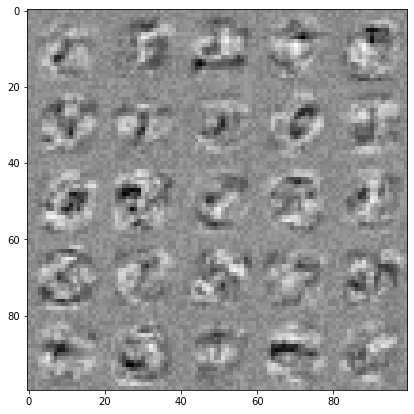

In [16]:
def visualizeHiddenLayer(Theta):
    #removing bias unit
    Theta = Theta[:,1:]
    assert Theta.shape == (25,400)
    
    w, h = 20, 20
    num_rows, num_cols = 5, 5
        
    grid_images = np.zeros((h*num_rows,w*num_cols))
    
    row_i, col_i = 0, 0
    for row in Theta:
        if col_i == num_cols:
            row_i += 1
            col_i  = 0
        # adding bias unit back in
        img_i = getImage(np.insert(row,0,1))
        grid_images[row_i*h:row_i*h+img_i.shape[0],col_i*w:col_i*w+img_i.shape[1]] = img_i
        col_i += 1
    figure = plt.figure(figsize=(7,7))
    image = toimage(grid_images)
    plt.imshow(image,cmap = cm.Greys_r)
    
visualizeHiddenLayer(final_Thetas[0])